In [23]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

print(torch.cuda.is_available())

True


## Import Datasets

In [24]:
# download and import data from open datasets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
)

## Wrap Datasets into DataLoader

In [25]:
batch_size = 64

# create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


- N merujuk pada jumlah sampel dalam suatu batch.
- C merujuk pada jumlah saluran atau channel dalam suatu citra.
- H merujuk pada tinggi atau jumlah baris piksel dalam citra.
- W merujuk pada lebar atau jumlah kolom piksel dalam citra.

## Creating Models

In [26]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [27]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

### Optimizing the Model Parameters

In [28]:
# create loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (feed forward to it in batches), and backpropagates the prediction error to adjust the model parameters

In [29]:
# create trainer function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 250 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [30]:
# create testing function to check model performance
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [31]:
# training process
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.295694  [   64/60000]
loss: 2.278235  [16064/60000]
loss: 2.229173  [32064/60000]
loss: 2.198641  [48064/60000]
Test Error: 
 Accuracy: 35.5%, Avg loss: 2.169880 

Epoch 2
-------------------------------
loss: 2.166792  [   64/60000]
loss: 2.135132  [16064/60000]
loss: 2.030191  [32064/60000]
loss: 1.973690  [48064/60000]
Test Error: 
 Accuracy: 52.9%, Avg loss: 1.928798 

Epoch 3
-------------------------------
loss: 1.946573  [   64/60000]
loss: 1.892251  [16064/60000]
loss: 1.704799  [32064/60000]
loss: 1.593277  [48064/60000]
Test Error: 
 Accuracy: 59.2%, Avg loss: 1.570178 

Epoch 4
-------------------------------
loss: 1.624218  [   64/60000]
loss: 1.574833  [16064/60000]
loss: 1.388434  [32064/60000]
loss: 1.252230  [48064/60000]
Test Error: 
 Accuracy: 62.7%, Avg loss: 1.291441 

Epoch 5
-------------------------------
loss: 1.360897  [   64/60000]
loss: 1.331465  [16064/60000]
loss: 1.182955  [32064/60000]
loss: 1.030541  [48064

### Saving Models

In [32]:
torch.save(model.state_dict(), "models/00-model.pth")
print("Saved PyTorch Model State to 00-model.pth")

Saved PyTorch Model State to 00-model.pth


---

### Loading Models

In [33]:
model_latest = NeuralNetwork().to(device)
model.load_state_dict(torch.load("models/00-model.pth"))

<All keys matched successfully>

Predicted: "Bag", Actual: "Bag"


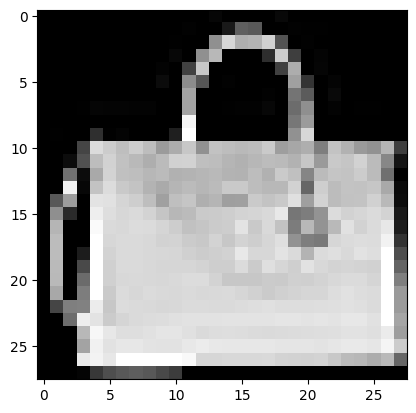

In [43]:
import matplotlib.pyplot as plt

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
data_id = 30
x, y = test_data[data_id][0], test_data[data_id][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
    plt.imshow(x.cpu().numpy().squeeze(), cmap="gray")